# Anisotropic case

As a proof of concept, we consider here the case of an elongated decahedron, built using ase.cluster.Decahedron function.


In [1]:
%matplotlib widget
#from NPScattering2D_numba_doublesum import NanoparticleScattering2D
from debye3D import Experiment,Debye3D
from ase.cluster import Decahedron,Icosahedron,Octahedron
from ase.io import write
import numpy as np
from debyecalculator import DebyeCalculator
from ase.visualize import view
import os
from matplotlib import pyplot as plt
from utilities import *

0. Create Experiment

In [2]:
wl = 1.54
distance = 0.36
npix = 2000
pix_size = 0.00015 # 150µum
exp = Experiment(wl=wl, distance=distance,npix=npix,pixel_size=pix_size)

----------------------------------------------------
 Detector configuration / accessible Q-range
----------------------------------------------------
 Wavelength λ = 1.5400 Å
 Sample-detector distance = 360.00 mm
 Pixel size = 0.150 mm
 Number of pixels = 2000 x 2000
 Qx range : -1.5692 → 1.5679 Å⁻¹
 Qy range : -0.5649 → 0.0000 Å⁻¹
 Qz range : -1.5692 → 1.5679 Å⁻¹
 |Q| range : 0.0000 → 2.1469 Å⁻¹
----------------------------------------------------



1. Create structure file using ase

The created nanoparticle is aligned along z axis

![Generated structure](figs/Dh_z.jpg)

In [3]:
atoms = Decahedron('Au',5,25,0)
print(f'The structure contains {len(atoms)} atoms')
file = f'./test.xyz'
atoms.write(file)



The structure contains 1329 atoms


2. create Debye3D instance

In [4]:
d3d = Debye3D(file, distance=exp.distance, wl= exp.wl, npix= exp.npix, pixel_size= exp.pixel_size)
#d3d.view_structure()

----------------------------------------------------
 Detector configuration / accessible Q-range
----------------------------------------------------
 Wavelength λ = 1.5400 Å
 Sample-detector distance = 360.00 mm
 Pixel size = 0.150 mm
 Number of pixels = 2000 x 2000
 Qx range : -1.5692 → 1.5679 Å⁻¹
 Qy range : -0.5649 → 0.0000 Å⁻¹
 Qz range : -1.5692 → 1.5679 Å⁻¹
 |Q| range : 0.0000 → 2.1469 Å⁻¹
----------------------------------------------------


 Structure contains 1329 atoms.



3. Rotate particle to align it along x (90° aorund Y)

![Particle is aligned alon x](figs/Dh_x.jpg)

In [5]:
d3d.rotate_positions(alpha=0,beta=90,gamma = 0)
#d3d.view_structure()


array([[-4.03899393e+01,  0.00000000e+00, -2.47317050e-15],
       [-3.75049437e+01,  0.00000000e+00, -2.29651546e-15],
       [-3.46199480e+01,  0.00000000e+00, -2.11986043e-15],
       ...,
       [ 2.88499567e+01,  2.94905510e-01, -8.59715516e+00],
       [ 3.17349523e+01,  2.94905510e-01, -8.59715516e+00],
       [ 3.46199480e+01,  2.94905510e-01, -8.59715516e+00]])

3. Compute 2D intensity and plot

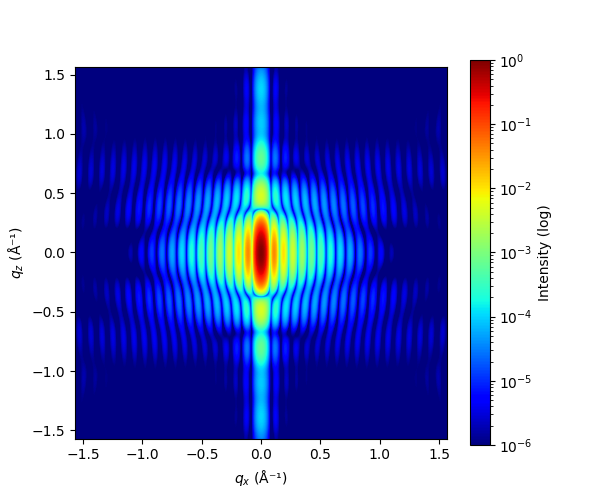

In [6]:
I=d3d.compute_intensity()
d3d.plot_intensity(I,vmin=-6)

4. integrate to obtain I(q)

In [7]:
q,i=d3d.integrate_with_pyfai(I)

  File "/home-local/ratel-ra/Documents/Python_code/Debye_3D/debye3D.py", line 414, in ai
    ai = AzimuthalIntegrator(dist=self.D, detector=detector)


### Moyenne orientationnelle utilisant la quadrature de Fibonacci

In [8]:
q_iso,i_iso = d3d.compute_isotropic_intensity_fibonacci()

5. make debye calculation using DebyeCalculator

In [9]:
q_dc, i_dc = d3d.compute_Iq_debyecalc()

/home-local/ratel-ra/Documents/Python_code/Debye_3D/debye3D.py:149: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled GPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator(qmin=self.q_min, qmax=self.q_max, qstep=qstep, biso=0, device='cuda')


6. plot to compare

Text(0, 0.5, 'I(q)')

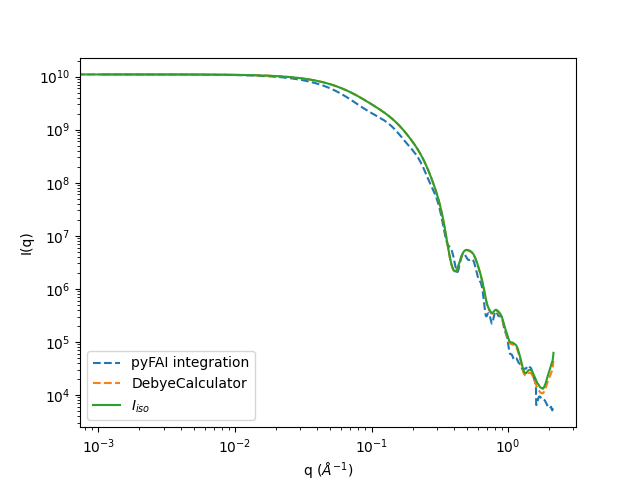

In [10]:
f0 = d3d.xray_f0(d3d.elements[0],q_dc)
N=d3d.nb_atoms

K=1

plt.figure()
plt.loglog(q,i,'--',label=f'pyFAI integration')
plt.loglog(q_dc,i_dc*K,'--',label=f'DebyeCalculator')
plt.loglog(q_iso,i_iso,label = '$I_{iso}$') 
plt.legend()
plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('I(q)')

## II. Compute Orientation Distribution

We consider a unixial orientation along x axis, and gaussian orientation distributions around y and z axes.
this calculation is implemented in the compute_intensity_uniaxial_ODF() method based on Monte Carlo sampling

In [15]:
I_dist = d3d.compute_intensity_uniaxial_ODF(n_samples=100,sigma_y=10,sigma_z=10)

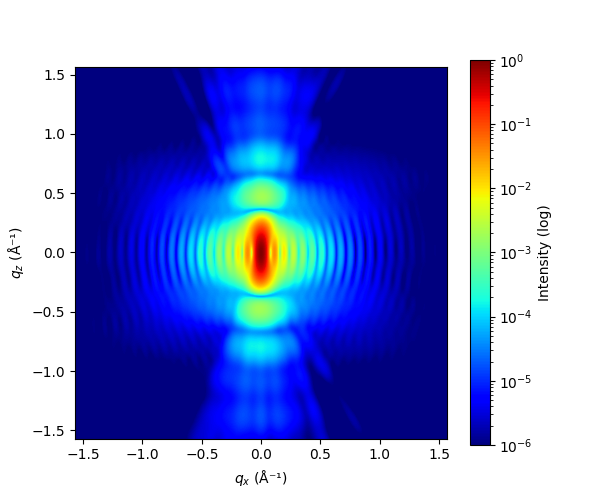

In [16]:
d3d.plot_intensity(I_dist)

# test des fonctions de sauvegarde copiées dans utilities.py

In [17]:
file='./Dh_uniaxial_orient_dist.npz'
save_intensity_npz(file,I_dist,d3d.Qx,d3d.Qz)


Saved intensity map to './Dh_uniaxial_orient_dist.npz'


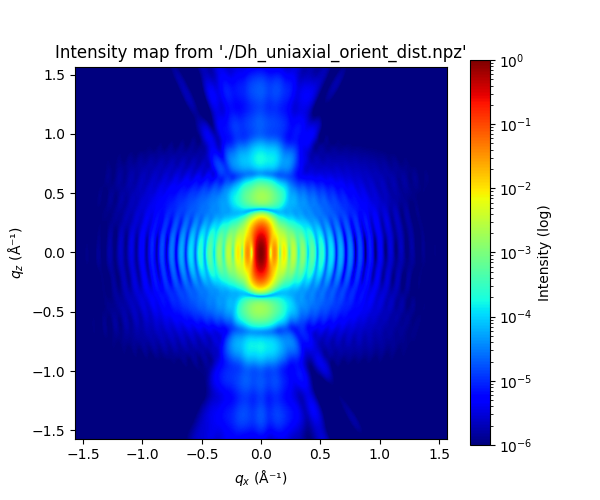

In [18]:
file='./Dh_uniaxial_orient_dist.npz'
plot_from_npz(file)